In [1]:
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
# import scipy.special as sc
from scipy.special import softmax

using dill to import product MDP generated offline, avoiding installation of rabinzer4 package

In [2]:
import dill
dill.load_session('product_MDP.pkl')
# dill.load_session('product_MDP_2_Gamma_0.9_0.9.pkl')
# dill.load_session('product_MDP_2_Gamma_0.8_0.4.pkl')
print(csrl.discount)
print(csrl.discountB)

0.99999
0.99


In [3]:
def one_trajectroy(initial_state,csrl,theta,length): 
    state   = initial_state
    reward  = csrl.reward[state]
    state_hist  = [state]
    reward_hist = [reward]
    gamma_hist  = [csrl.discountB if reward else csrl.discount]
    action_hist = []
    for t in range(T):
        A_set = csrl.A[state]
        # softmax, from theta to probability
        # Policy, action distributation given state and theta
        action = A_set[np.random.choice(len(A_set),p= softmax_state(theta,state,csrl) )]
        states, probs = csrl.transition_probs[state][action]
        state = states[np.random.choice(len(states),p=probs)]
        reward = csrl.reward[state]
        gamma = csrl.discountB if reward else csrl.discount
        state_hist.append(state)
        reward_hist.append(reward)
        gamma_hist.append(gamma)
        action_hist.append(action)
    state_hist  = state_hist[:-1]
    reward_hist = reward_hist[:-1]
    gamma_hist  = gamma_hist[:-1]
    G_t = reward_hist[-1]
    G_t_hist = [G_t]
    for t in range(T-2,-1,-1):
        G_t = reward_hist[t] + gamma_hist[t] * G_t
        G_t_hist.append(G_t)
    G_t_hist.reverse()
    return state_hist, action_hist, G_t_hist, gamma_hist

def transition_matrix():
    # policy_dist =  np.zeros(theta.shape)
    dim = csrl.shape[:-1][0]*csrl.shape[:-1][1]*csrl.shape[:-1][2]*csrl.shape[:-1][3]
    P_pi = np.zeros([dim,dim])
    index = 0
    R_pi = np.zeros([dim,1])
    for i,q,r,c in csrl.states():
        state = (i,q,r,c)
        R_pi[index] = csrl.reward[state]
        A_set   = csrl.A[state]
        # softmax, from theta to probability
        Policy_s_theta = softmax_state(theta,state,csrl)
        states_array = []    
        probs_array = []
        for action in A_set:
            Pi_A_theta = Policy_s_theta[A_set.index(action)]
            if action < len(csrl.mdp.A): # MDP actions
                q_ = oa.delta[q][csrl.mdp.label[r,c]]  # OA transition
                mdp_states, probs = csrl.mdp.get_transition_prob((r,c),csrl.mdp.A[action])  # MDP transition
                states = [(i,q_,)+s for s in mdp_states]
                probs = np.array(probs) * Pi_A_theta
                probs = probs.tolist()
            else:  # epsilon-actions
                states, probs = ([(i,action-len(csrl.mdp.A),r,c)], [1.])
                probs = np.array(probs) * Pi_A_theta
                probs = probs.tolist()
            states_array = states_array +  states
            probs_array = probs_array + probs
    
        for k in range(len(states_array)):
            s_plus = states_array[k]
            s_plus = s_plus[1]*csrl.shape[:-1][2]*csrl.shape[:-1][3] +  s_plus[2]*csrl.shape[:-1][3] +  s_plus[3]
            # s_plus = int(s_plus)
            P_pi[s_plus,index] = probs_array[k] + P_pi[s_plus,index]            
        index = index +1
    return P_pi, R_pi

def softmax_state(theta,state,csrl):
    Action_set = csrl.A[state]  
    # temp = theta[state][:len(Action_set)] / np.linalg.norm(theta[state][:len(Action_set)])
    temp = theta[state][:len(Action_set)]
    Policy_A_theta = softmax(temp)
#     Policy_A_theta = np.exp(temp) / np.sum(np.exp(temp))
    return Policy_A_theta

def derivate_softmax(theta,state,csrl,action,Policy_A_theta):
    Action_set = csrl.A[state]
    P_a = Policy_A_theta[Action_set.index(action)]
    Grad_Pi = np.zeros([len(Action_set),1])
    for i in range(len(Grad_Pi)):
        if i == Action_set.index(action):
            Grad_Pi[i] = P_a*(1-P_a)
        else:
            Grad_Pi[i] = -P_a * Policy_A_theta[i]
    return Grad_Pi

this derivate_softmax is $\frac{\partial \pi(a_t|s)}{\partial \theta} $

In [4]:
#%%
T = 30
K = 6000
csrl.discount = 0.99999
csrl.discountB = 0.99

$T$ batch size, $K$ steps, set $\gamma>\gamma_B$

In [ ]:
#%%
theta = np.ones(csrl.shape)
V = np.zeros(csrl.shape[:-1])
V_hist = np.zeros([K+1] + list(csrl.shape[:-1]) )
Policy_hist = np.zeros([K+1] + list(csrl.shape[:-1]) )

theta_hist = np.zeros( [K+1] + list(csrl.shape) )
theta_hist[0] = theta
eig_max_hist = np.zeros([K])
eig_min_hist = np.zeros([K])
di_norm_hist = np.zeros([K])

for k in tqdm(range(K)):
    # k_th episode
    # initial state
    state   = (csrl.shape[0]-1,csrl.oa.q0)+(csrl.mdp.random_state())
    reward  = csrl.reward[state]
# =============================================================================
# simulate and record 1 trajectroy,
    state_hist  = [state]
    reward_hist = [reward]
    gamma_hist  = [csrl.discountB if reward else csrl.discount]
    action_hist = []
    for t in range(T):
        A_set = csrl.A[state]
        # softmax, from theta to probability
        # Policy, action distributation given state and theta
        Policy_s_theta = softmax_state(theta,state,csrl)
        action = A_set[np.random.choice(len(A_set),p=Policy_s_theta)]
        states, probs = csrl.transition_probs[state][action]
        state = states[np.random.choice(len(states),p=probs)]
        reward = csrl.reward[state]
        gamma = csrl.discount
        
        state_hist.append(state)
        reward_hist.append(reward)
        gamma_hist.append(gamma)
        action_hist.append(action)
    state_hist  = state_hist[:-1]
    reward_hist = reward_hist[:-1]
    gamma_hist  = gamma_hist[:-1]
    G_t = reward_hist[-1]
    G_t_hist = [ G_t]
    for t in range(T-2,-1,-1):
        G_t = reward_hist[t] + gamma_hist[t] * G_t
        G_t_hist.append(G_t)
    G_t_hist.reverse()
# =============================================================================
# use 1 trajectory to generate policy gradient and update parameter once, 
    # alpha = np.max((1.0*(1 - 1.5*k/K),0.001))
    alpha = 1
    PG = np.zeros(csrl.shape)
    Grad_theta_Pi = np.zeros(csrl.shape)
    Grad_V = np.zeros(csrl.shape[:-1])
    for t in range(T):
        state   = state_hist[t]
        action  = action_hist[t]
        A_set   = csrl.A[state]
        # softmax, from theta to probability
        Policy_s_theta = softmax_state(theta,state,csrl)
        Pi_A_theta = Policy_s_theta[A_set.index(action)]
        # derivate of log softmax, pi w.r.t. theta
        Grad_Pi = derivate_softmax(theta,state,csrl,action,Policy_s_theta) / Pi_A_theta
        

        PG_state = np.prod(gamma_hist[0:t:1]) * (G_t_hist[t] + V[state_hist[-1]]- V[state]) *  Grad_Pi 
        PG[state][0:len(PG_state):1] += PG_state.flatten()
        Grad_V[state] = Grad_V[state] + (G_t_hist[t]- V[state])  
        
        Grad_log_Pi_state = np.prod(gamma_hist[0:t:1]) * Grad_Pi /T
        Grad_theta_Pi[state][0:len(PG_state):1] += Grad_log_Pi_state.flatten()
        
    FIM = Grad_theta_Pi.flatten().reshape(-1,1)  @ Grad_theta_Pi.flatten().reshape(-1,1).T
    # FIM = np.eye(640)
    
    # eig = np.linalg.eigvals(FIM)
    # eig_max_hist[k] = eig.max()
    # eig_min_hist[k] = eig.min()
    # x = cg( FIM, PG.flatten() )
    # x =  np.linalg.pinv(FIM+ 0.1*np.eye(640) ) @ PG.flatten()
    x =  np.linalg.pinv(FIM) @ PG.flatten()
    delta = 0.05
    x_THx = x.reshape(-1,1).T @ FIM @ x.reshape(-1,1)
    di = np.sqrt( 2*delta / (x_THx if x_THx else 1) )   * x
    # di = np.sqrt( 2*delta / (x.reshape(-1,1).T @ FIM @ x.reshape(-1,1) if x.reshape(-1,1).T @ FIM @ x.reshape(-1,1) else 1) )   * x
    # di = np.sqrt(     2*delta/ x.reshape(-1,1).T @ FIM @ x.reshape(-1,1)  )   * x
    di = di.reshape(theta.shape)
    # di_norm_hist[k] = np.linalg.norm(di)
    # theta = theta   +   alpha * di / T
    theta = theta   +   0.5*di/T
    V =     V       +   Grad_V/T
        
    V_hist[k+1] = V
    theta_hist[k+1] = theta
# =============================================================================

 94%|█████████▍| 5649/6000 [11:43<00:41,  8.38it/s]

choose a random initial state, generate 1 trajectory $\tau$, use this trajectory to update $\theta$ once,
$ \theta = \theta + \mathbb{E}_\tau \big{[} [G_t + \hat{V}(s_T) - \hat{V}(s_t)]   \nabla_{\theta} \log (\pi_{\theta}(a_t|s_t))\big{]}\big{]}$

FIM is given as 
$\mathbb{E}_\tau \big{[}\nabla_{\theta} \log(\pi(a_t|s_t)) \nabla_{\theta} \log(\pi(a_t|s_t))^T \big{]}$

In [6]:
#%% from theta to policy
policy = np.zeros(csrl.shape[:-1])
for i,q,r,c in csrl.states():
    state = (i,q,r,c)
    # temp = theta[state][0:len(csrl.A[state])]
    temp = theta[state][csrl.A[state]]
    policy[state] = np.argmax(temp)
    policy = policy.astype(int)
print('policy')
print(policy[0,0])
print('value')
print( np.around( (np.sum(V_hist[round(k/10*9):k:1],axis=0)/(k/10))[0,0],decimals = 2 ))

policy
[[1 3 1 1]
 [2 2 2 2]
 [0 1 4 0]
 [0 2 4 3]
 [0 0 0 3]]
value
[[0.   0.   0.   0.11]
 [0.   0.01 0.07 0.23]
 [0.   0.02 0.   0.14]
 [0.21 0.12 0.22 0.12]
 [0.11 0.   0.08 0.  ]]


use PR-averging, take avergae of a portition tail as result, 

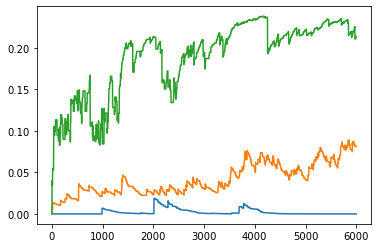

In [7]:
#%%
plt.figure()
# plt.hold(True)
plt.plot(range(k),V_hist[0:k:1,0,0,0,0])
plt.plot(range(k),V_hist[0:k:1,0,0,1,2])
plt.plot(range(k),V_hist[0:k:1,0,0,1,3])

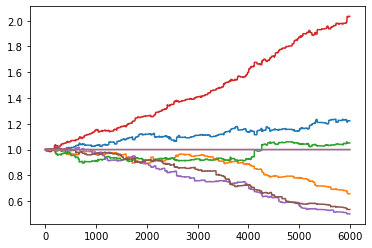

In [8]:
#%%
plt.figure()
plt.plot(range(k),theta_hist[0:k:1,0,0,3,3])